# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

from pandas import read_csv

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


ModuleNotFoundError: No module named 'mendeleev'


# Function that sets up HNC QSP 

### Create and run plasma

In [2]:
name='Al'
Z, A = 13, 27
mi = m_p * A
ρ_gpercc =  2.7 
ni_cc = ρ_gpercc/(mi*AU_to_g)
ri_cm = rs_from_n(ni_cc)
ri_AU = ri_cm*cm_to_AU

Te_eV = 1
Ti_eV = 1

ri_AU
Zbar = 3

### Make βu_ii, βu_fi from using bound density from AA
If we assume the bound state does not deform at all, then we can calculate potentials based on it easily via integration

### Solving

In [3]:
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

def custom_flat(hnc_matrix):
    hnc_flat = np.concatenate([hnc_matrix[0,0],hnc_matrix[0,1],hnc_matrix[1,1]])
    return hnc_flat

def custom_unflat(hnc_flat):
    hnc00, hnc01, hnc11 = np.split(hnc_flat,3)
    hnc_matrix = np.zeros((2,2,len(hnc00)))
    hnc_matrix[0,0] = hnc00
    hnc_matrix[1,0] = hnc01
    hnc_matrix[0,1] = hnc01
    hnc_matrix[1,1] = hnc11
    return hnc_matrix

def solve_least_squares(plasma, sparse_k_array, c_s_k_guess=None, ftol=1e-8):
    if c_s_k_guess is None:
        c_s_k_guess = plasma.hnc.c_s_k_matrix

    # Create functions for converting between sparse, not sparse and flattened versions of c_s_k
    get_sparse_csk = lambda c_s_k_flat: np.concatenate([interp1d(plasma.hnc.k_array, c_s_k)(sparse_k_array) for c_s_k in np.split(c_s_k_flat,3) ])
    get_csk = lambda sparse_hnc_csk: interp1d(sparse_k_array, sparse_hnc_csk, kind='cubic')(plasma.hnc.k_array)
    get_csk_matrix_from_sparse_csk_flat =  lambda sparse_c_s_k_flat: custom_unflat(np.concatenate([get_csk(sparse_csk) for sparse_csk in np.split(sparse_c_s_k_flat,3)]))
    
    def min_function(sparse_c_s_k_flat):
        c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sparse_c_s_k_flat)
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        plasma.hnc.c_s_k_matrix = new_c_s_k_matrix.copy()
        new_c_s_k_flat = custom_flat(new_c_s_k_matrix)
        return sparse_c_s_k_flat - get_sparse_csk(new_c_s_k_flat)
    
    c_s_k_flat_guess = custom_flat(c_s_k_guess)
    c_s_k_sparse_guess = get_sparse_csk(c_s_k_flat_guess)
    sol = least_squares(min_function, c_s_k_sparse_guess, verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    plasma.hnc.c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sol.x)
    plasma.hnc.set_all_matrices_from_csk(plasma.hnc.c_s_k_matrix)
    print(sol)

def best_shift(plasma, guess_c_s_k, ftol=1e-8, set=True):
    
    def min_function(multiplier_list):
        xii, xei, xee = multiplier_list
        multiplier_matrix = np.array([[xii,xei],[xei,xee]])
        c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * guess_c_s_k
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        
        return c_s_k_matrix.flatten() - new_c_s_k_matrix.flatten()
    
    sol = least_squares(min_function, np.ones((3)) , verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    xii, xei, xee = sol.x
    multiplier_matrix = np.array([[xii,xei],[xei,xee]])
    
    plasma.hnc.c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * guess_c_s_k
    print(sol)
    return sol

### Testing Ashcroft Smoothed
The regular ashcroft potential is 
$$ \beta v^A_{ei} = 
\left\{\begin{array}{ll}
 -\alpha \bar{Z}/R_c &  r<= R_c \\ 
 -\bar{Z}/r & r > R_c
\end{array}\right\}
$$

or in k-space
$$
\beta \tilde{v}^A_{ei} = -\frac{4\pi\bar{Z}}{k^2} \left( \cos(k R_c)(1-\alpha) + \alpha\sin(k R_c)/ k R_c  \right)
$$
We smooth the Ashcroft potential to account for finite electron spread as 
$$
\beta \tilde{v}^{SA}_{ei} = -4\pi\bar{Z}\left( \frac{1}{k^2} - \frac{1}{k^2+1/\Lambda_{ei}^2}  \right) \left( \cos(k R_c)(1-\alpha) + \alpha \sin(k R_c)/ k R_c  \right)
$$
for $\Lambda_{ij} = \sqrt{2\pi \mu_{ij} T_{ij}}$ the inter-particle thermal deBroglie wavelength.
One can verify that setting $R_c=0$ and FTing reduces to the Deutsch potential
$$
\beta v^D = \frac{\beta Z}{r} \left( 1- e^{r/\Lambda_{ei}}   \right)
$$


In [4]:
def make_Ashcroft_βvei(atom, α=1, Rc = 0.4):
    k = atom.hnc.k_array
    βvei= atom.hnc.FT_k_2_r(  4*π*atom.qsp.Γei* (np.cos(k*Rc)*(1-α) + α*np.sin(k*Rc)/(k*Rc)) * (1/k**2 - 1/(k**2 + 1/atom.qsp.Λei**2)) )
    atom.hnc.βu_r_matrix[0,1] = βvei
    atom.hnc.βu_r_matrix[1,0] = βvei
    atom.hnc.set_βu_matrix(atom.hnc.βu_r_matrix)


In [30]:
def plasma_f(α, Rc, closure='svt'):
    plasma = PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=False,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options = {'Te_c_type':'VMC'},
             hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':closure},
             hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':500},
             root_options={'options':{'maxfev':100,'xtol':1e-14}})
    
    # Make the smoothed Ashcroft potential 
    make_Ashcroft_βvei(plasma, α=α, Rc = Rc)
    
    return plasma

In [58]:
# Rc_list = np.array([0.6,0.8])
Rc_list = np.array([0.6])
color_list = plt.cm.coolwarm(np.linspace(0,1,len(Rc_list) ))
color_indexes = range(len(color_list))

# α_list = np.array([1,1.4,1.5,1.6])
α_list = np.array([1.5,1.7,1.9])
style_list = ['-','--',':','-.','--.'][:len(α_list)]

Num_params = len(α_list)*len(Rc_list)
params_list = np.array(np.meshgrid(α_list,Rc_list)).T.reshape(Num_params,2)
line_list = np.array(np.meshgrid(style_list,color_indexes)).T.reshape(Num_params,2)

plasma_list = [[]]*len(params_list)

# c_s_k_guess = None
for i, params in enumerate(params_list):
    α, Rc = params
    print(i,": ",α, Rc)
    plasma = plasma_f(α, Rc, closure='svt')
    plasma.run_hnc(newton=False)#, c_s_k_guess = c_s_k_guess)
    plasma_list[i] = plasma
    # c_s_k_guess = plasma.hnc.c_s_k_matrix.copy()
    # best_shift(plasma, c_s_k_guess.copy(), ftol=1e-8, set=True)
    # solve_least_squares(plasma, np.linspace(plasma.hnc.k_array[0], plasma.hnc.k_array[-1], num=1000))

0 :  1.5 0.6
Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 1.271e+01
Starting Ng loop, using best index so far:  499
Exiting status 0, reverting to best index so far: 509
Final iter:512, Total Error: 5.473e-09
1 :  1.7 0.6
Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 1.271e+01
QUIT: Last 10 iterations error has been increasing
Exiting status 2, reverting to best index so far: 194
Final iter:203, Total Error: 6.011e-02
2 :  1.9 0.6
Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 1.270e+01
QUIT: Total error infinite.
Exiting status 1, reverting to best index so far: 137
Final iter:142, Total Error: 1.663e-01


/home/zach/plasma/hnc/hnc/hnc.py:416: RuntimeWarning: overflow encountered in exp
  tot_eqn =  1 + h_r_matrix  - np.exp(-self.βu_s_r_matrix + h_r_matrix - c_s_r_matrix )


In [59]:
for plasma in [ plasma_list[1], plasma_list[2]]:
    solve_least_squares(plasma, np.linspace(plasma.hnc.k_array[0], plasma.hnc.k_array[-1], num=250))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0104e+00                                    2.50e+01    
       1              2         1.1493e-01      1.90e+00       1.60e+00       7.28e+00    
       2              3         1.0593e-03      1.14e-01       2.07e+00       5.36e-01    
       3              4         1.4654e-06      1.06e-03       6.10e-01       2.64e-02    
       4              5         4.0364e-09      1.46e-06       6.91e-03       1.07e-03    
       5              6         6.6447e-12      4.03e-09       3.76e-04       3.84e-05    
       6              7         1.0459e-15      6.64e-12       1.81e-05       4.41e-07    
       7              8         2.0261e-17      1.03e-15       3.19e-07       6.97e-08    
`xtol` termination condition is satisfied.
Function evaluations 8, initial cost 2.0104e+00, final cost 2.0261e-17, first-order optimality 6.97e-08.
     message: `xtol` termination 

In [60]:
for plasma in [ plasma_list[1], plasma_list[2]]:
    solve_least_squares(plasma, np.linspace(plasma.hnc.k_array[0], plasma.hnc.k_array[-1], num=1000))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2080e-03                                    2.90e-01    
       1              2         7.1159e-07      4.21e-03       1.84e-01       8.20e-03    
       2              3         2.9509e-10      7.11e-07       6.90e-03       1.69e-04    
       3              4         2.0491e-14      2.95e-10       1.17e-04       1.35e-06    
       4              5         2.1582e-17      2.05e-14       4.14e-07       4.50e-08    
`xtol` termination condition is satisfied.
Function evaluations 5, initial cost 4.2080e-03, final cost 2.1582e-17, first-order optimality 4.50e-08.
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-2.480e-09 -2.439e-09 ... -5.134e-18  1.578e-18]
           x: [ 7.885e+01  7.820e+01 ... -9.061e-10 -3.017e-10]
        cost: 2.1581801716605072e-17
         jac: [[ 9.984e-01 -1.087e-02 ... -0.000e

### Plot and Comparison to QMD

In [23]:
ocp =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=False,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':500},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})
ocp.run_ocp_hnc();
yp =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=False,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':500},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})
yp.run_yukawa_hnc();

# custom = PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=False,
#                  βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
#                  hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
#                  hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':1000},
#                  root_options={'options':{'maxfev':100,'xtol':1e-14}})

# custom.run_ocp_hnc();
# # custom.ocp_hnc.set_βu_matrix(np.array([[330/(custom.hnc.r_array)**1*np.exp(-3*custom.hnc.r_array) + 0.75/custom.hnc.r_array**3*np.cos(-4*custom.hnc.r_array + 1.5)  ]]))
# custom.ocp_hnc.set_βu_matrix(np.array([[custom.qsp.Γii/custom.hnc.r_array**1.4 - custom.hnc.Bridge_function_Yukawa(custom.hnc.r_array, custom.qsp.Γii, custom.qsp.get_κ())]]))
# # custom.ocp_hnc.set_βu_matrix(np.array([[custom.qsp.Γii/custom.hnc.r_array]])) 
# custom.ocp_hnc.initialize_c_k()
# custom.ocp_hnc.set_C_matrix()
# # custom.ocp_hnc.c_s_k_matrix = c_s_k_guess.copy()
# custom.ocp_hnc.HNC_solve(**ocp.hnc_solve_options)


# custom2 = PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=False,
#                  βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
#                  hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
#                  hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':1000},
#                  root_options={'options':{'maxfev':100,'xtol':1e-14}})

# custom2.run_ocp_hnc();
# # custom2.ocp_hnc.set_βu_matrix(np.array([[330/(custom2.hnc.r_array)**1*np.exp(-3*custom2.hnc.r_array) + 0.75/custom2.hnc.r_array**3*np.cos(-4*custom2.hnc.r_array + 1.5)  ]]))
# custom2.ocp_hnc.set_βu_matrix(np.array([[0.5*custom2.qsp.Γii/custom2.hnc.r_array**1 - custom2.hnc.Bridge_function_Yukawa(custom2.hnc.r_array, custom2.qsp.Γii, custom2.qsp.get_κ())]]))
# # custom2.ocp_hnc.set_βu_matrix(np.array([[custom2.qsp.Γii/custom2.hnc.r_array]])) 
# custom2.ocp_hnc.initialize_c_k()
# custom2.ocp_hnc.set_C_matrix()
# # custom2.ocp_hnc.c_s_k_matrix = c_s_k_guess.copy()
# custom2.ocp_hnc.HNC_solve(**ocp.hnc_solve_options)

Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 2.552e+01
Starting Ng loop, using best index so far:  499
Exiting status 0, reverting to best index so far: 512
Final iter:515, Total Error: 9.836e-09
Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 2.507e+02
Starting Ng loop, using best index so far:  499
Exiting status 0, reverting to best index so far: 499
Final iter:502, Total Error: 2.870e-09


In [8]:
MD_data = read_csv("/home/zach/plasma/datasets/RDFs/Al_1.0eV_rs3_VASP.txt",  header=1)
MD_data.columns=['r','g']
MD_data;

/tmp/ipykernel_2834956/1072604354.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(plasma.hnc.r_array, plasma.hnc.h_r_matrix[0,0]+1,'-', color=color, linestyle=style, label=r"$\alpha, R_c$ = {0:.2f}, {1:.2f}".format(α,Rc))


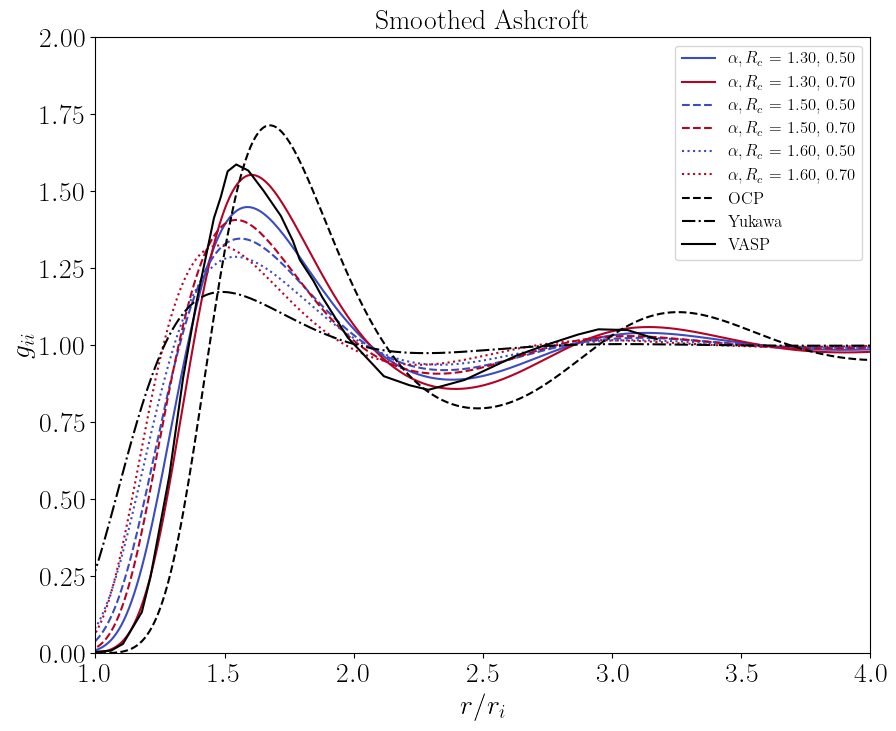

In [36]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Smoothed Ashcroft", fontsize=20)


# Model Comparison
for i, ( line, params, plasma) in enumerate(zip(line_list, params_list, plasma_list)):
    # if i==6:
    #     continue
    α, Rc = params
    color, style = color_list[int(line[1])], line[0]
    ax.plot(plasma.hnc.r_array, plasma.hnc.h_r_matrix[0,0]+1,'-', color=color, linestyle=style, label=r"$\alpha, R_c$ = {0:.2f}, {1:.2f}".format(α,Rc))

# OCP
ax.plot(ocp.ocp_hnc.r_array, ocp.ocp_hnc.h_r_matrix[0,0]+1,'k--', label='OCP')
ax.plot(yp.yuk_hnc.r_array, yp.yuk_hnc.h_r_matrix[0,0]+1,'k-.', label='Yukawa')
# ax.plot(custom.ocp_hnc.r_array, custom.ocp_hnc.h_r_matrix[0,0]+1,'g-.', label=r'$\Gamma_{ii}/r^{1.4}$')
# ax.plot(custom2.ocp_hnc.r_array, custom2.ocp_hnc.h_r_matrix[0,0]+1,'b-.', label=r'$\Gamma_{ii}/r^{0.8}$')

# Data
ax.plot(MD_data['r'], MD_data['g'], 'k',label='VASP')

# Plotting functions
# ax.set_title(r"$R_c = {}$".format(Rc),fontsize=20)
ax.set_xlim(1,4)
ax.set_ylim(0,2)
ax.set_ylabel(r'$g_{ii}$',fontsize=20)
ax.set_xlabel(r'$r/r_i$ ',fontsize=20)
ax.tick_params(labelsize=20)
# ax.set_yscale('symlog', linthresh=2)

# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=12, loc='upper right')


In [34]:
from scipy.signal import find_peaks

print("Data: ", [MD_data['r'][indx] for indx in find_peaks(np.abs(MD_data['g']-1))[0]])

def get_peaks(hnc):
    peak_locs = [
        hnc.r_array[index] for index in find_peaks(np.abs(hnc.h_r_matrix[0,0]))[0]]
    first_peak_index = np.argmin(np.abs(np.array(peak_locs)-1.5))
    second_peak_index = np.argmin(np.abs(np.array(peak_locs)-2.2))
    third_peak_index = np.argmin(np.abs(np.array(peak_locs)-3.2))
    return [peak_locs[index] for index in [first_peak_index,second_peak_index,third_peak_index]]

# Model Comparison
for i, ( line, params, plasma) in enumerate(zip(line_list, params_list, plasma_list)):
    α, Rc = params
    print(α, Rc, get_peaks(plasma.hnc))

for hnc in [ocp.ocp_hnc, custom.ocp_hnc, custom2.ocp_hnc]:
    print(get_peaks(hnc))

Data:  [1.5448504983388704, 2.2890365448504983, 2.946843853820598]
1.3 0.5 [1.59, 2.38, 3.13]
1.3 0.7 [1.6, 2.39, 3.14]
1.5 0.5 [1.56, 2.35, 3.1]
1.5 0.7 [1.54, 2.33, 3.06]
1.6 0.5 [1.54, 2.33, 3.09]
1.6 0.7 [1.48, 2.25, 2.97]


NameError: name 'custom' is not defined

### Plot S(k)

In [ ]:
ocp.ocp_hnc.S_k_matrix[0,0,0], yp.yuk_hnc.S_k_matrix[0,0,0]

/tmp/ipykernel_2834956/1013508481.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(plasma.hnc.k_array, np.sum(plasma.hnc.rho)/plasma.hnc.rho[0]*plasma.hnc.S_k_matrix[0,0]-1,'-', color=color, linestyle=style, label=r"$\alpha, R_c$ = {0:.2f}, {1:.2f}".format(α,Rc))


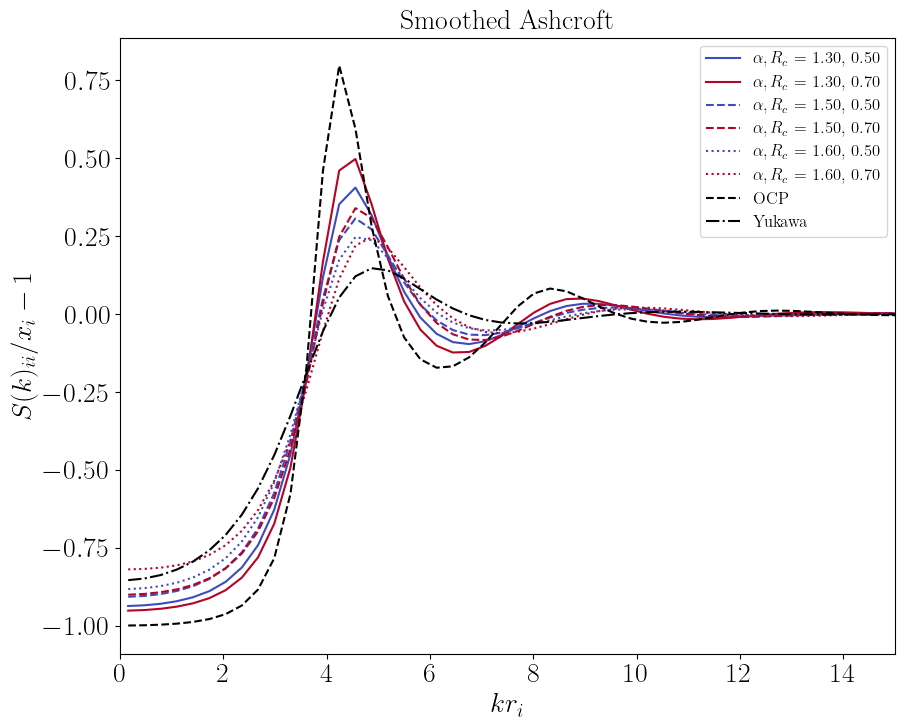

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Smoothed Ashcroft", fontsize=20)


# Model Comparison
for i, ( line, params, plasma) in enumerate(zip(line_list, params_list, plasma_list)):
    # if i==6:
    #     continue
    α, Rc = params
    color, style = color_list[int(line[1])], line[0]
    ax.plot(plasma.hnc.k_array, np.sum(plasma.hnc.rho)/plasma.hnc.rho[0]*plasma.hnc.S_k_matrix[0,0]-1,'-', color=color, linestyle=style, label=r"$\alpha, R_c$ = {0:.2f}, {1:.2f}".format(α,Rc))

# OCP
ax.plot(ocp.ocp_hnc.k_array, np.sum(ocp.ocp_hnc.rho)/ocp.ocp_hnc.rho[0]*ocp.ocp_hnc.S_k_matrix[0,0]-1,'k--', label='OCP')
ax.plot(yp.yuk_hnc.k_array, np.sum(yp.yuk_hnc.rho)/yp.yuk_hnc.rho[0]*yp.yuk_hnc.S_k_matrix[0,0]-1,'k-.', label='Yukawa')
# ax.plot(custom.ocp_hnc.r_array, custom.ocp_hnc.h_r_matrix[0,0]+1,'g-.', label=r'$\Gamma_{ii}/r^{1.4}$')
# ax.plot(custom2.ocp_hnc.r_array, custom2.ocp_hnc.h_r_matrix[0,0]+1,'b-.', label=r'$\Gamma_{ii}/r^{0.8}$')

# Data
# ax.plot(MD_data['r'], MD_data['g'], 'k',label='VASP')

# Plotting functions
# ax.set_title(r"$R_c = {}$".format(Rc),fontsize=20)
ax.set_xlim(0,15)
# ax.set_ylim(0,2)
ax.set_ylabel(r'$S(k)_{ii}/x_i-1$',fontsize=20)
ax.set_xlabel(r'$k r_i$ ',fontsize=20)
ax.tick_params(labelsize=20)
# ax.set_yscale('symlog', linthresh=0.1)

# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=12, loc='upper right')



### Effective Potential

In [39]:
for i, (color, params, plasma) in enumerate(zip(colors, params_list, plasma_list)):
    α, Rc = params
    plasma.hnc.invert_HNC_OZ([1])
    ax.plot(plasma.hnc.r_array, plasma.hnc.βueff_r_matrix[0,0],'-', color=color,label=r"$\alpha, R_c$ = {0:.2f}, {1:.2f}".format(α,Rc))

    # np.savetxt(f"/home/zach/plasma/hnc/TCCW/data/dcf_data/{name}_{Ti_eV:0.2e}eV_rs{ri_AU:0.3f}_svt-hnc-softAshcroft-Rc{Rc:0.2f}-α1_c_k_matrix.csv", plasma.hnc.c_k_matrix.reshape(4,atom2.hnc.N_bins))

/tmp/ipykernel_2834956/887985946.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(plasma.hnc.r_array, plasma.hnc.βueff_r_matrix[0,0],'-', color=color, linestyle=style, label=r"$\alpha, R_c$ = {0:.2f}, {1:.2f}".format(α,Rc))


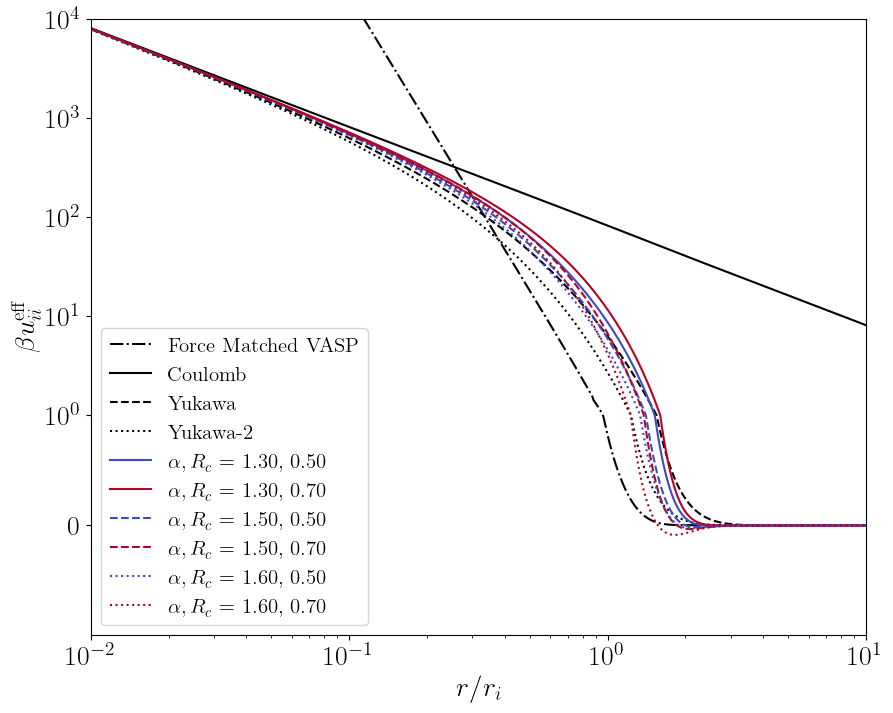

In [41]:
Luke_pair = read_csv("../data/Al_T1_tab.lammps.PAIR", delim_whitespace=True, header=4)


fig, ax = plt.subplots(figsize=(10,8))

# LUKE Potfit VASP
ax.plot(Luke_pair['r[A]']*Angstrom_to_AU/ri_AU, plasma.qsp.βie_c*Luke_pair['u[eV]']*eV_to_AU, 'k-.',label='Force Matched VASP')
# ax.plot(Luke_pair['r[A]']*Angstrom_to_AU/ri_AU, 1/(Luke_pair['r[A]']*Angstrom_to_AU/ri_AU)**4.25, 'k:',label='Force Matched VASP')
# Coulomb and Yukawa
yp.yuk_hnc.invert_HNC_OZ([])
# custom.ocp_hnc.invert_HNC_OZ([])
ax.plot(plasma.hnc.r_array, plasma.hnc.βu_r_matrix[0,0],'k-', label='Coulomb')
ax.plot(plasma.hnc.r_array, plasma.qsp.βv_Yukawa(plasma.hnc.r_array),'k--', label='Yukawa')
ax.plot(plasma.hnc.r_array, yp.yuk_hnc.βueff_r_matrix[0,0],'k:', label='Yukawa-2')
# ax.plot(plasma.hnc.r_array, custom.ocp_hnc.βueff_r_matrix[0,0],'r--', label='Custom')

# Model Comparison
for i, ( line, params, plasma) in enumerate(zip(line_list, params_list, plasma_list)):
    if i==6:
        continue
    α, Rc = params
    color, style = color_list[int(line[1])], line[0]
    plasma.hnc.invert_HNC_OZ([1])
    ax.plot(plasma.hnc.r_array, plasma.hnc.βueff_r_matrix[0,0],'-', color=color, linestyle=style, label=r"$\alpha, R_c$ = {0:.2f}, {1:.2f}".format(α,Rc))


# ax.set_title(r"$R_c = {}$".format(Rc),fontsize=20)
ax.set_xlim(1e-2,10)
ax.set_ylim(-1,1e4)
ax.set_ylabel(r'$\beta u^{\text{eff}}_{ii}$',fontsize=20)
ax.set_xlabel(r'$r/r_i$ ',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_yscale('symlog', linthresh=1)
ax.set_xscale('log')
# ax.set_yscale('log')

ax.legend(fontsize=15)

In [ ]:
# np.savetxt("Al1_βu_eff_raw.txt", np.array([plasma_list[2].hnc.r_array,plasma_list[2].hnc.βueff_r_matrix[0,0] ]).T, header='r/r_i 			 βuii_eff(r/r_i)')
# np.savetxt("Al1_g_r_raw.txt", np.array([plasma_list[2].hnc.r_array,plasma_list[2].hnc.h_r_matrix[0,0]+1, plasma_list[2].hnc.h_r_matrix[1,0]+1,plasma_list[2].hnc.h_r_matrix[1,1]+1 ]).T, header='r/r_i 				 gii(r/r_i) 				 gie(r/r_i) 				 gee(r/r_i)')

In [ ]:
# AA_data = read_csv("/home/zach/plasma/atoMEC/examples/density.csv", delim_whitespace=True, header=0)

fig, ax = plt.subplots(figsize=(10,8))

# Model Comparison
for i, (color, Rc, plasma) in enumerate(zip(colors, Rc_list, plasma_list)):
    if i>2:
        continue
    ax.plot(plasma.hnc.r_array, plasma.hnc.h_r_matrix[0,0]+1,'-', color=color,label=r"$R_c$ = {0:.2f}".format(Rc))
    ax.plot(plasma.hnc.r_array, plasma.hnc.h_r_matrix[0,1]+1,'--', color=color)#,label=r"$R_c$ = {0:.2f}".format(Rc))
    ax.plot(plasma.hnc.r_array, plasma.hnc.h_r_matrix[1,1]+1,'-.', color=color)#,label=r"$R_c$ = {0:.2f}".format(Rc))
    

ax.plot(MD_data['r'], MD_data['g'], 'k-',label='VASP')

# ax.plot(atom_oz.hnc.r_array*atom_oz.qsp.ri, atom_oz.hnc.h_r_matrix[0,0]+1,'--', label='my OZ CHNC')

ax.set_xlim(0,3)
ax.set_ylabel(r'$g_{ii}$',fontsize=20)
ax.set_xlabel(r'$r$ [A.U.]',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_yscale('symlog', linthresh=2)
ax.set_ylim(0,None)
# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=15)

#### Save DCF

In [ ]:
# np.savetxt(f"/home/zach/plasma/hnc/TCCW/data/dcf_data/{name}_{Ti_eV:0.2e}eV_rs{ri_AU:0.3f}_oz-hnc-Pauli-bound-dist_c_k_matrix.csv", atom1.hnc.c_k_matrix.reshape(4,atom1.hnc.N_bins))
# np.savetxt(f"/home/zach/plasma/hnc/TCCW/data/dcf_data/{name}_{Ti_eV:0.2e}eV_rs{ri_AU:0.3f}_svt-hnc-softAshcroft-Rc0p2_c_k_matrix.csv", atom2.hnc.c_k_matrix.reshape(4,atom2.hnc.N_bins))
# np.savetxt(f"/home/zach/plasma/hnc/TCCW/data/dcf_data/{name}_{Ti_eV:0.2e}eV_rs{ri_AU:0.3f}_svt-hnc-Pauli-bound-point_c_k_matrix.csv", atom3.hnc.c_k_matrix.reshape(4,atom3.hnc.N_bins))

### Bound and Free state Examination

(0.9940305, 0.9293877688069333, 0.0854256084615352, 0.2502350500388202)

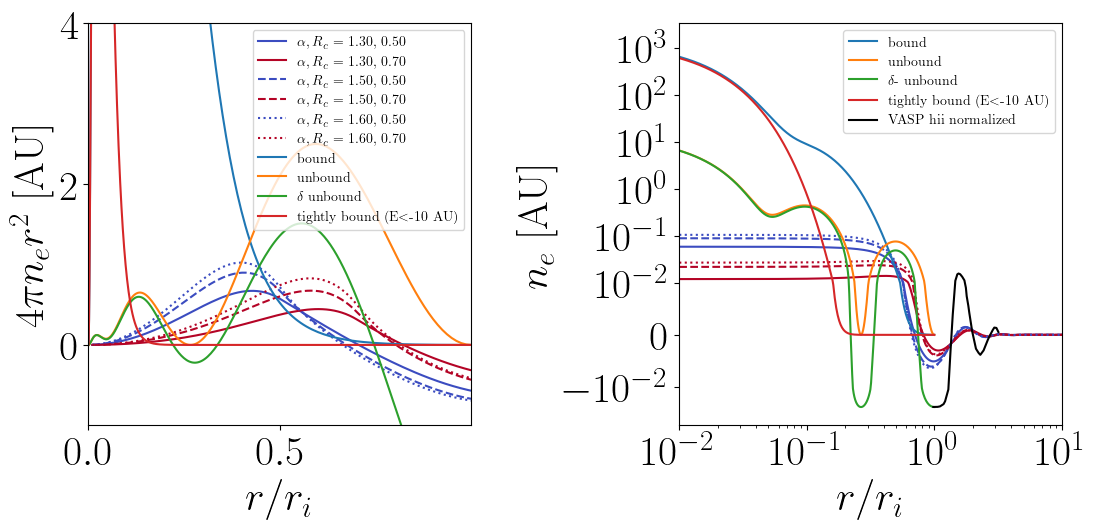

In [57]:
from scipy.integrate import simpson

ne_bar = Zbar*plasma.qsp.ni

bound_file = "/home/zach/plasma/hnc/TCCW/data/Al_ri_2.989_T_1.000e+00eV.csv"
AA_data = read_csv(bound_file, delim_whitespace=True, header=0)
AA_r_AU_full = np.array(AA_data['r[a_0]'])
AA_nb_AU_full = np.array(AA_data['n(bound)'])
AA_nub_AU_full = np.array(AA_data['n(unbound)'])
AA_ntb_AU_full = np.array(AA_data['n(tightbound)'])
N_b, N_ub, N_tb = simpson(4*π*AA_nb_AU_full*AA_r_AU_full**2,  AA_r_AU_full), simpson(4*π*AA_nub_AU_full*AA_r_AU_full**2,  AA_r_AU_full), simpson(4*π*AA_ntb_AU_full*AA_r_AU_full**2,  AA_r_AU_full)
# Get Zbar
Zbar =  Z - simpson(4*π*AA_nb_AU_full*AA_r_AU_full**2,  AA_r_AU_full)


# Plot bound states
fig, axs = plt.subplots(1,2, figsize=(12,6))


# Model Comparison
for i, ( line, params, plasma) in enumerate(zip(line_list, params_list, plasma_list)):
    if i==6:
        continue
    α, Rc = params
    color, style = color_list[int(line[1])], line[0]
    nb_hnc = (plasma.hnc.h_r_matrix[0,1]+1)*ne_bar
    δnb_hnc = (plasma.hnc.h_r_matrix[0,1])*ne_bar
    r_hnc = plasma.hnc.r_array*plasma.qsp.ri

    axs[0].plot(plasma.hnc.r_array, 4*π*r_hnc**2*δnb_hnc, color=color, linestyle=style, label=r"$\alpha, R_c$ = {0:.2f}, {1:.2f}".format(α,Rc))
    axs[1].plot(plasma.hnc.r_array, δnb_hnc, color=color, linestyle=style)


    
# # Model Comparison
# for i, (color, params, plasma) in enumerate(zip(colors, params_list, plasma_list)):
#     α, Rc = params
#     nb_hnc = (plasma.hnc.h_r_matrix[0,1]+1)*ne_bar
#     δnb_hnc = (plasma.hnc.h_r_matrix[0,1])*ne_bar
#     r_hnc = plasma.hnc.r_array*plasma.qsp.ri
#     axs[0].plot(plasma.hnc.r_array, 4*π*r_hnc**2*δnb_hnc,'--', color=color,label=r"$\alpha, R_c$ = {0:.2f}, {1:.2f}".format(α,Rc))
#     axs[1].plot(plasma.hnc.r_array, δnb_hnc,'--', color=color)#,label=r"$R_c$ = {0:.2f}".format(Rc))


axs[0].set_ylabel(r'$4 \pi n_e r^2$ [AU]')
axs[0].plot(AA_r_AU_full/plasma.qsp.ri, 4*π*AA_nb_AU_full*AA_r_AU_full**2, label='bound')
axs[0].plot(AA_r_AU_full/plasma.qsp.ri, 4*π*AA_nub_AU_full*AA_r_AU_full**2, label='unbound')
axs[0].plot(AA_r_AU_full/plasma.qsp.ri, 4*π*(AA_nub_AU_full-ne_bar)*AA_r_AU_full**2, label=r'$\delta$ unbound')
axs[0].plot(AA_r_AU_full/plasma.qsp.ri, 4*π*AA_ntb_AU_full*AA_r_AU_full**2, label=r'tightly bound (E$<$-10 AU)')
axs[0].set_ylim(-1, 4)
axs[0].set_xlim(0, np.max(AA_r_AU_full/plasma.qsp.ri))

axs[1].set_ylabel(r'$n_e$ [AU]')
axs[1].plot(AA_r_AU_full/plasma.qsp.ri, AA_nb_AU_full, label='bound')
axs[1].plot(AA_r_AU_full/plasma.qsp.ri, AA_nub_AU_full, label='unbound')
axs[1].plot(AA_r_AU_full/plasma.qsp.ri, AA_nub_AU_full-ne_bar, label=r'$\delta$- unbound')
axs[1].plot(AA_r_AU_full/plasma.qsp.ri, AA_ntb_AU_full, label=r'tightly bound (E$<$-10 AU)')
axs[1].set_xscale('log')
axs[1].set_yscale('symlog',linthresh=1e-2)
axs[1].set_xlim(1e-2, plasma.hnc.r_array[-1])
# axs[1].set_ylim(-0.1,0.1)

# Data
axs[1].plot(MD_data['r'], ne_bar*(MD_data['g']-1), 'k',label='VASP hii normalized')


for ax in axs:
    # ax.axvspan(AA_r_AU_full[0]/plasma.qsp.ri, min_r_to_use/plasma.qsp.ri, color='k', alpha=0.1)
    ax.set_xlabel(r'$r/r_i$')
    # ax.set_xlim(np.min(AA_r_AU_full/plasma.qsp.ri), np.max(AA_r_AU_full/plasma.qsp.ri))
    ax.legend(fontsize=10)
plt.tight_layout()

AA_r_AU_full[915],r_hnc[30], simpson((4*π*r_hnc**2*δnb_hnc)[:30], x=r_hnc[:30]), simpson(4*π*(AA_nub_AU_full*AA_r_AU_full**2)[:915],  AA_r_AU_full[:915])

In [45]:
# Model Comparison
for i, ( line, params, plasma) in enumerate(zip(line_list, params_list, plasma_list)):
    α, Rc = params
    color, style = color_list[int(line[1])], line[0]
    nub_hnc = (plasma.hnc.h_r_matrix[0,1]+1)*ne_bar
    δnub_hnc = (plasma.hnc.h_r_matrix[0,1])*ne_bar
    r_hnc = plasma.hnc.r_array*plasma.qsp.ri

    print(simpson(4*π*r_hnc**2*δnub_hnc,r_hnc))

0.18736003911320454
0.14300188399263805
0.27608716186582233
0.29624454350432666
0.3500449772442682
0.5402737553282712


In [44]:
np.sqrt(simpson(AA_nb_AU_full*AA_r_AU_full**4,AA_r_AU_full)/simpson(AA_nb_AU_full*AA_r_AU_full**2,AA_r_AU_full))/ri_AU

0.2076981737367827

# Transport
## Born Green Viscocity
See [Morioka 2004](https://www.sciencedirect.com/science/article/pii/S0022309304003692)

\begin{align}
η = f_{BG} \frac{2 \pi}{15} \left(\frac{M}{RT} \right)^{1/2} \frac{n^2}{N_a} \int^\infty_0 g(r) \frac{d\phi}{dr}r^4 dr
\end{align}
Resulting units is Pa s


In [ ]:
from scipy.integrate import simpson

def get_ηBG(plasma, plot=False):
    plasma.hnc.invert_HNC_OZ([1])
    fBG = -1
    n_AU = n_from_rs(plasma.qsp.ri)
    r_array = plasma.hnc.r_array*plasma.qsp.ri
    gii = plasma.hnc.h_r_matrix[0,0]+1
    dφdr = plasma.qsp.Ti*np.gradient(plasma.hnc.βueff_r_matrix[0,0], r_array)

    integrand = r_array**4 * gii * dφdr
    if plot==True:
        fig, ax = plt.subplots()
        ax.plot(r_array, dφdr*r_array**4)
    
    integral = simpson(integrand, x=r_array)
    η = fBG* 2*π/15 * (plasma.qsp.βi*plasma.qsp.m_i)**0.5*n_AU**2*integral
    return η

# Model Comparison
for i, ( line, params, plasma) in enumerate(zip(line_list, params_list, plasma_list)):
    α, Rc = params
    η_SI = get_ηBG(plasma)*AU_to_Pa*AU_to_s # Pa s = kg m^-1 s^-1 
    print(f"α={α}, Rc={Rc}")
    # print(f"\tSI: η = {η_SI:0.3e} [kg m^-1 s^-1] (or [Pa s])")
    η_cgs = η_SI * 1000/100 # g cm^-1 s^-1
    print(f"\tCGS: η = {η_cgs:0.3e} [g cm^-1 s^-1]")

In [ ]:
Zbar_list  = np.linspace(3,Zbar, num=100)
# Zbar_list = [1,3]
atom_list= []
for i, Zbar_i in enumerate(Zbar_list):
    print("Zbar = {0:.3f}".format( Zbar_i ))
    
    atom = PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar_i, 
                 βu_options = {'add_bridge':True}, 
                 qsp_options={'r_c':0},
                 hnc_options={'kappa_multiscale':10},
                 hnc_solve_options={'alpha_Picard':0.5})
    if i>=1:
        Z2_matrix = [[Zbar_list[i]]]
        # guess_2 = 
        c_s_k_guess = atom_list[-1].hnc.c_s_k_matrix
        c_s_k_guess[0,0] *= (Zbar_list[i]/Zbar_list[i-1])**2 
        c_s_k_guess[0,1] *= (Zbar_list[i]/Zbar_list[i-1])**1 
        c_s_k_guess[1,0] *= (Zbar_list[i]/Zbar_list[i-1])**1
#         c_s_k_guess[0,0] *= 0
    else:
        c_s_k_guess *=0
    atom.run_hnc(c_s_k_guess=c_s_k_guess)
    atom_list.append( atom )

In [ ]:
fig, axs = plt.subplots(2, 2, facecolor='w', figsize=(10,8) )

atom3_guess = atom2.hnc.c_s_k_matrix + (atom2.hnc.c_s_k_matrix-atom1.hnc.c_s_k_matrix)/(2-1)*(3-2) 
atom3_guess = atom2.hnc.c_s_k_matrix + (atom2.hnc.c_s_k_matrix/atom1.hnc.c_s_k_matrix)/(2-1)*(3-2) 

for i in range(2):
    for j in range(2):
        for k, atom in enumerate(atom_list):
            color = plt.cm.viridis(k/len(atom_list))
            Z_factor = (Zbar_list[0]/Zbar_list[k])**-1
            axs[i, j].plot(atom.hnc.r_array, atom.hnc.c_s_k_matrix[i,j], '--',label= "Zbar", color= color)
            axs[i, j].plot(atom.hnc.r_array, Z_factor*atom_list[0].hnc.c_s_k_matrix[i,j],'.', label= "Zbar", color= color)
#             axs[i, j].plot(atom.hnc.r_array, atom2.hnc.c_s_k_matrix[i,j], label= "Zbar=2")
#             axs[i, j].plot(atom.hnc.r_array, atom6.hnc.c_s_k_matrix[i,j], label= "Zbar=6")
#         axs[i, j].plot(atom2.hnc.r_array, atom2.hnc.c_s_k_matrix[i,j]-atom1.hnc.c_s_k_matrix[i,j], label= "Zbar=2/1")
#         axs[i, j].plot(atom2.hnc.r_array, atom3.hnc.c_s_k_matrix[i,j]-atom2.hnc.c_s_k_matrix[i,j], label= "Zbar=3/2")
#         axs[i, j].plot(atom2.hnc.r_array, atom3_guess[i,j] , 'k--', label= "Zbar=3 (guess)")
        
#         axs[i, j].plot(atom3.hnc.r_array, atom3.hnc.c_s_k_matrix[i,j],'k', label= "Zbar=3")
#         axs[i, j].plot(atom100.hnc.r_array, atom80.hnc.c_s_k_matrix[i,j]-100/80*atom100.hnc.c_s_k_matrix[i,j], label= "80/100 eV")
#         axs[i, j].plot(atom100.hnc.r_array, atom60.hnc.c_s_k_matrix[i,j], label= "60 eV")
         
#         axs[i, j].plot(atom100.hnc.r_array, T_rescale[i,j]*atom100.hnc.c_s_k_matrix[i,j], label= "rescaled 100 eV")
        
        axs[i,j].set_xscale('log')
#         axs[i, j].set_yscale('symlog', linthresh=0.1)
#         axs[i, j].legend()
        
plt.tight_layout()

In [ ]:
atom.get_cp(ε_derivative=1e-6, ε_table=1e-1, N_table= 2 )

In [ ]:
fig, ax = plt.subplots()

# ax.plot(atom.hnc.r_array, atom.hnc.βueff_r_matrix[0,0])
ax.plot(atom.hnc.r_array, atom.hnc.h_r_matrix[0,0]+1)
# ax.set_yscale('symlog', linthresh=1)

###### Hydrogen H1

c_p = 1.667e+08 [J/m^3/K] = 1.667e+09 [erg/cc/K]


c_p^ideal = 2.064e+07 [J/m^3/K] = 2.064e+08 [erg/cc/K]

c_v = 1.229e+08 [J/m^3/K] = 1.229e+09 [erg/cc/K]


γ = cp/cv = 1.357e+00

###### Aluminum Al1

c_p = 5.560e+06 [J/m^3/K] = 5.560e+07 [erg/cc/K]

c_p^ideal = 2.081e+06 [J/m^3/K] = 2.081e+07 [erg/cc/K]

c_v = 3.559e+06 [J/m^3/K] = 3.559e+07 [erg/cc/K]

c_p_over_nkB = 6.678

c_v_over_nkB = 4.275

γ = cp/cv = 1.562e+00

##### Carbon C1

c_p = 1.005e+09 [J/m^3/K] = 1.005e+10 [erg/cc/K]

c_p^ideal = 1.729e+07 [J/m^3/K] = 1.729e+08 [erg/cc/K]

c_v = 7.410e+08 [J/m^3/K] = 7.410e+09 [erg/cc/K]

γ = cp/cv = 1.357e+00

##### Copper Cu1
c_p = 6.829e+07 [J/m^3/K] = 6.829e+08 [erg/cc/K]

c_p^ideal = 2.930e+06 [J/m^3/K] = 2.930e+07 [erg/cc/K]

c_v = 4.460e+07 [J/m^3/K] = 4.460e+08 [erg/cc/K]

γ = cp/cv = 1.531e+00

In [ ]:
# Compare to Ichimaru
n_AU = ni_cc * (1e2*aB)**3
E_over_nkBT = atom.U/( Te*N )
P_over_nkBT = atom.P/(Te*n_AU)
c_p_over_nkB = C_p_AU/N #c_p_SI_vol/k_B/(ni_cc*1e6)
E_over_nkBT, P_over_nkBT, c_p_over_nkB  

In [ ]:
# 2x2
#(16.078004224152146, 7.958852940677674, 20.391840227664225)
# 3x3
#(17.29156071613095, 9.41653222069282, 19.954770080816058)
# 4x4
#(17.29156071613095, 9.41653222069282, 20.31577883096223)
# 6x6
#(17.29156071613095, 9.41653222069282, 20.341775951597302)



In [ ]:
#cp units are J/K/m^3

In [ ]:
c_p_SI_vol *J_to_erg*1e-6 # from J/K/m^3 to erg/K/cc

In [ ]:
(c_p_over_nkB*ni_cc * k_B*1e6)/1e8 # in erg/

In [ ]:
# Ideal
# (1.503495387998133, 1.0020009999999997, 2.5033223241241656)


# βu_eff matching

In [ ]:
from pandas import read_csv
from scipy.interpolate import interp1d
# luke_file = '/home/zach/plasma/atomic_forces/data/Al_T0p5_tab.lammps.PAIR'
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T1_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
# luke_r, luke_βV = 1e-10/aB/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r, luke_βV = 1e-8/ri_AU*luke_data['r [A]'], 1/(Te_eV)*luke_data['V [eV]']
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

In [ ]:
from scipy.optimize import curve_fit

class βu_fit():
    def __init__(self, func, r_array, y_data, initial_guess):
        self.r = r_array
        self.y = y_data
        self.y_vals = curve_fit(func, r_array, y_data, maxfev=int(1e5), p0=initial_guess)
        self.y_fit  = func(r_array, *self.y_vals[0])
        self.err = np.linalg.norm(self.y_fit-self.y)
        print(func.__name__ + " error: {0:.3e} ".format(self.err))

def yukawa(r, Γ, κ):
    return  Γ/r*np.exp(-κ*r)

def yukawa_plus(r, a, b, c, d):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d)))

def yukawa_plus_gaussian(r, a ,b ,c, d ,e, f, g):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g)

def yukawa_plus_cos(r, a ,b ,c, d , h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)

def yukawa_plus_gaussian_cos(r, a ,b ,c, d ,e, f, g, h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.cos((r-f)*g*np.exp(-h*r))*np.exp(-i*r) + j*np.exp(-(k-r)**2/l)


In [ ]:
atom, atomqsp = plasma.hnc, plasma.qsp

In [ ]:
atom.invert_HNC_OZ([1])
fit1 = βu_fit(yukawa, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[   atomqsp.Γii, atomqsp.get_κ()])
try: 
    fit2 = βu_fit(yukawa_plus_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit1.y_vals[0], 1, 0.01, 1 , 10, 2])
except:
    pass
try:
    fit3 = βu_fit(yukawa_plus_gaussian_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit2.y_vals[0], -1, 1.9, 1])
except:
    pass

In [ ]:
from hnc.hnc.misc import P_Ideal_Fermi_Gas

fig, ax = plt.subplots(figsize=(10,8),facecolor='w')
# fig.suptitle(r"{0} $T=${1:.1f} eV, $r_i$={2:.2f}".format(case_id, Te/eV, atomqsp.ri), fontsize=20)

#Compare to Yukawa and Coulomb
coulomb_matrix = (atom.Γ_matrix[:,:,np.newaxis]/atom.r_array) [:-1,:-1]

ax.plot(atom.r_array, atom.βu_r_matrix[0,0], 'k--',label='Initial')
ax.plot(plasma.hnc.r_array, plasma.qsp.βv_Yukawa(plasma.hnc.r_array),'k--', label='Yukawa')

# Plot effective potential and fit
for i, plasma in enumerate(plasma_list):
    if i>2:
        continue
    fit = βu_fit(yukawa, atom.r_array, plasma.hnc.βueff_r_matrix[0,0], initial_guess=[   atomqsp.Γii, atomqsp.get_κ()])
    ax.plot(atom.r_array, plasma.hnc.βueff_r_matrix[0,0],color=colors[i], label= r"$\beta u^{\text{eff}}_{ii}$")    
    ax.plot(fit.r, fit.y_fit, color=colors[0],linestyle='--',label=r"$\beta u^{\text{eff}}_{ii}$ Yukawa Fit")




# LUKE Potfit VASP
ax.plot(Luke_pair['r[A]']*Angstrom_to_AU/ri_AU, plasma.qsp.βie_c*Luke_pair['u[eV]']*eV_to_AU, 'r-.',label='Force Matched VASP')

ax.tick_params(labelsize=20)
ax.set_xlabel(r"$r/r_s$",fontsize=20)
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)

ax.set_xlim(1e-2, 3)
# ax.set_xscale('log')
ax.set_yscale('symlog',linthresh=1)
# ax.set_yscale('log')
# ax.set_ylim(np.min([-10, 2*np.min(atom.βueff_r_matrix[0,0])]), np.max([1e3, 2*np.max(atom.βueff_r_matrix[0,0])]))
ax.set_ylim(-1e0,1e3)
ax.tick_params(labelsize=15)
ax.legend(fontsize=10)


fig.tight_layout()